# Polar model / Trained on rotated CelebA / Tested on rotated CelebA

In [1]:
from tensorflow.keras import datasets, layers, models

import cv2 as cv
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import os
import matplotlib.pyplot as plt
import time

In [2]:
# To run on GPU, can be omitted for CPU only
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Function to get vertical cylinder effect - mentioned in paper
def padImage(image, pixels=5):
    bottom = image[-pixels:]
    top = image[:pixels]

    img = np.insert(image, 0, bottom, 0)
    img = np.insert(img, len(img), top, 0)
    return img

In [4]:
mni = np.load('celeb_rgb_ds.npz')
train_images = mni['arr_0']
train_labels = mni['arr_1']
test_images = mni['arr_2']
test_labels = mni['arr_3']

In [5]:
train_images = np.reshape(train_images, (-1, 64, 64, 3))
test_images = np.reshape(test_images, (-1, 64, 64, 3))

## Sample of original image

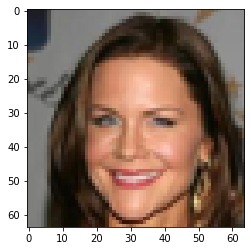

In [6]:
plt.imshow(test_images[3])

## Prepare Dataset

In [7]:
X_train_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in train_images]
X_train_polar = [cv.linearPolar(x, tuple(np.array(x.shape[1::-1])/2), 30, cv.WARP_FILL_OUTLIERS) for x in X_train_polar]
X_train_polar = [padImage(x, pixels=5) for x in X_train_polar]
X_train_polar = np.array(X_train_polar)

X_test_polar = [cv.linearPolar(x, tuple(np.array(x.shape[1::-1])/2), 30, cv.WARP_FILL_OUTLIERS) for x in test_images]
X_test_polar = [padImage(x, pixels=5) for x in X_test_polar]
X_test_polar = np.array(X_test_polar)

# Rotate test set
X_test_r_polar = [tfa.image.rotate(x, np.random.uniform(-np.pi/2., np.pi/2.)).numpy() for x in test_images]
X_test_r_polar = [cv.linearPolar(x, tuple(np.array(x.shape[1::-1])/2), 30, cv.WARP_FILL_OUTLIERS) for x in X_test_r_polar]
X_test_r_polar = [padImage(x, pixels=5) for x in X_test_r_polar]
X_test_r_polar = np.array(X_test_r_polar)

In [8]:
print(X_train_polar.shape)
print(X_test_polar.shape)
print(X_test_r_polar.shape)

(162770, 74, 64, 3)
(19962, 74, 64, 3)
(19962, 74, 64, 3)


## Sample of polar image

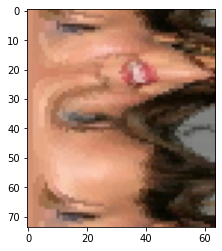

In [9]:
plt.imshow(X_test_polar[3])

## Model architecture

In [10]:
model = models.Sequential()
model.add(layers.Input(shape=(X_train_polar.shape[1:])))
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D())
model.add(layers.LayerNormalization(axis=-1, epsilon=0.001, center=True, scale=True))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))

model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(64, activation='linear'))
model.add(layers.Activation('relu'))
model.add(layers.Dense(1))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 74, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 37, 32, 32)        0         
_________________________________________________________________
layer_normalization (LayerNo (None, 37, 32, 32)        64        
_________________________________________________________________
dropout (Dropout)            (None, 37, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 16, 64)        0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 18, 16, 64)        1

## Model Training

In [12]:
name = 'polar_celeb'
checkpoint = tf.keras.callbacks.ModelCheckpoint(name + '.h5', verbose=1, save_best_only=True, monitor='val_accuracy', mode='max')

opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.fit(X_train_polar, train_labels, batch_size=32, epochs=25, 
          validation_data=(X_test_r_polar, test_labels),
          callbacks=[checkpoint])

Epoch 1/25
5087/5087 [==============================] - 68s 13ms/step - loss: 0.6733 - accuracy: 0.5654 - val_loss: 0.6625 - val_accuracy: 0.6953

Epoch 00001: val_accuracy improved from -inf to 0.69532, saving model to polar_celeb.h5
Epoch 2/25
5087/5087 [==============================] - 60s 12ms/step - loss: 0.5725 - accuracy: 0.6840 - val_loss: 0.8935 - val_accuracy: 0.6482

Epoch 00002: val_accuracy did not improve from 0.69532
Epoch 3/25
5087/5087 [==============================] - 62s 12ms/step - loss: 0.5314 - accuracy: 0.7180 - val_loss: 1.0672 - val_accuracy: 0.6150

Epoch 00003: val_accuracy did not improve from 0.69532
Epoch 4/25
5087/5087 [==============================] - 68s 13ms/step - loss: 0.5171 - accuracy: 0.7295 - val_loss: 1.0002 - val_accuracy: 0.6389

Epoch 00004: val_accuracy did not improve from 0.69532
Epoch 5/25
5087/5087 [==============================] - 66s 13ms/step - loss: 0.5027 - accuracy: 0.7417 - val_loss: 0.8163 - val_accuracy: 0.6873

Epoch 00005:

## Model Accuracies

In [13]:
def sigmoid(x):
    return 1./(1 + np.exp(-x))

In [14]:
m = tf.keras.models.load_model('polar_celeb.h5')

preds_plain = m.predict(X_test_polar)
preds_plain = sigmoid(preds_plain)
preds_plain = [0 if x <= 0.5 else 1 for x in preds_plain]

preds_rotated = m.predict(X_test_r_polar)
preds_rotated = sigmoid(preds_rotated)
preds_rotated = [0 if x <= 0.5 else 1 for x in preds_rotated]

# Plain accuracy
accuracy = np.mean(preds_plain == test_labels)*100
# "Rotated" accuracy
accuracy_rotated = np.mean(preds_rotated == test_labels)*100

print(accuracy)
print(accuracy_rotated)

74.85221921651137
75.58360885682798


## Prediction time for test set

In [15]:
times = []

for _ in range(0, 50):
    start = time.time()

    model.predict(X_test_polar)

    end = time.time()
    times.append(end - start)

print(np.mean(times))



2.382244462966919


## Prediction time per image

In [16]:
np.mean(times) / len(X_test_polar)

0.00011933896718599936